In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ast
import math
from advisor_client.client import *
client = AdvisorClient()

In [2]:
# get study
study_name = "optimal_jump1"
study = client.get_study_by_name(study_name)
print(study)

Id: 1, name: optimal_jump1, study_configuration: {"randomInitTrials": 20, "params": [{"parameterName": "jump_a", "type": "DOUBLE", "maxValue": 5.0, "minValue": -5.0}, {"parameterName": "jump_b", "type": "DOUBLE", "maxValue": 5.0, "minValue": -5.0}, {"parameterName": "jump_c", "type": "DOUBLE", "maxValue": 5.0, "minValue": -5.0}, {"parameterName": "jump_d", "type": "DOUBLE", "maxValue": 4.0, "minValue": 0}, {"parameterName": "opt_vel", "type": "DOUBLE", "maxValue": 6.0, "minValue": 3.0}], "goal": "MINIMIZE"}, algorithm: BayesianOptimization


Is study done: True
Best epoch: 116
Best trial: Id: 117, study_name: optimal_jump1, name: BayesianOptimizationTrial, parameter_values: {"opt_vel": 4.596537474770841, "jump_d": 0.4890559381359454, "jump_c": 1.3134926320091527, "jump_b": 0.7610068726541019, "jump_a": 4.388992036656301}, objective_value: 24.6798548521


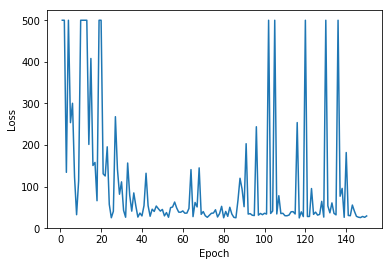

In [3]:
# plot training curve
scale = 500
train_curve = []
train_param = []
trials = client.list_trials(study_name)

for trial in trials:
    trial_metrics = client.list_trial_metrics(study_name,trial.id)
    train_param.append(ast.literal_eval(trial.parameter_values))
    for metrics in trial_metrics:
        train_curve.append(metrics.objective_value)

for param,objval in zip(train_param,train_curve):
    param["objective_value"] = objval

train_curve = np.clip(np.array(train_curve),0,scale)
best_trial = client.get_best_trial(study_name)
best_objval = round(best_trial.objective_value,3)
print("Is study done: %r"%client.is_study_done(study_name))
print("Best epoch: %d"%np.argmin(train_curve))
print("Best trial: {}".format(best_trial))

plt.plot(range(1,len(train_curve)+1),train_curve)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("./records/loss_"+str(best_objval)+"_"+str(scale)+".png")
plt.show()

max objval: 26.257
{'opt_vel': 4.596537474770841, 'objective_value': 24.6798548521, 'jump_d': 0.4890559381359454, 'jump_c': 1.3134926320091527, 'jump_b': 0.7610068726541019, 'jump_a': 4.388992036656301}
{'opt_vel': 4.5955960778382705, 'objective_value': 24.9820369497, 'jump_d': 0.21579566001401673, 'jump_c': 1.191126908498533, 'jump_b': 1.5127156196596117, 'jump_a': 4.347950527173232}
{'opt_vel': 4.645585558974596, 'objective_value': 25.0693205505, 'jump_d': 0.055425727125133495, 'jump_c': 1.2058931926986496, 'jump_b': 1.6312636744459628, 'jump_a': 3.9913784872251448}
{'opt_vel': 3.949631547787659, 'objective_value': 25.0741981518, 'jump_d': 0.9869605870854521, 'jump_c': 1.3946546400266469, 'jump_b': -0.06608679598147393, 'jump_a': 4.988928525288269}
{'opt_vel': 4.536812356587703, 'objective_value': 25.5082264716, 'jump_d': 0.41899059028293095, 'jump_c': 1.339751792561307, 'jump_b': 0.786072433798763, 'jump_a': 4.14557887881174}
{'opt_vel': 4.477131591432144, 'objective_value': 26.0137

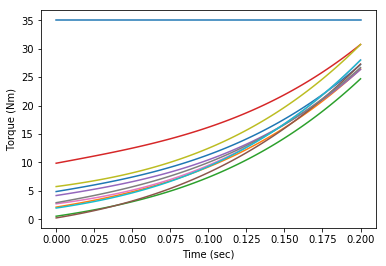

In [4]:
train_curve = np.array(train_curve)
topk_idx = np.argsort(train_curve)[:10]
print("max objval: %.3f"%max(train_curve[topk_idx]))
t = np.linspace(0,0.2,100)
y_constant = 35*np.ones_like(t)
for idx in topk_idx:
    param = train_param[idx]
    print(param)
    a = param["jump_a"]
    b = param["jump_b"]
    c = param["jump_c"]
    d = param["jump_d"]
    y_poly = (10*a * t + 100*b * t ** 2 + 1000*c * t ** 3 + 10*d)
    plt.plot(t,y_poly)
plt.plot(t,y_constant)
plt.xlabel("Time (sec)")
plt.ylabel("Torque (Nm)")
plt.show()

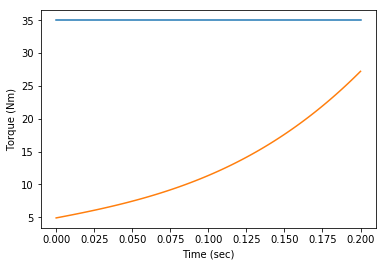

{'opt_vel': 4.596537474770841, 'jump_d': 0.4890559381359454, 'jump_c': 1.3134926320091527, 'jump_b': 0.7610068726541019, 'jump_a': 4.388992036656301}


In [5]:
param_dic = ast.literal_eval(best_trial.parameter_values)
a = param_dic["jump_a"]
b = param_dic["jump_b"]
c = param_dic["jump_c"]
d = param_dic["jump_d"]
t = np.linspace(0,0.2,100)
y_constant = 35*np.ones_like(t)
y_poly = (10*a * t + 100*b * t ** 2 + 1000*c * t ** 3 + 10*d)

plt.plot(t,y_constant)
plt.plot(t,y_poly)
plt.xlabel("Time (sec)")
plt.ylabel("Torque (Nm)")
plt.savefig("./records/torque_"+str(best_objval)+".png")
plt.show()
print(param_dic)

In [7]:
# display the best trial
with open("./controllers/my_controller_python/args.txt",'w') as f1:
    f1.write(str(param_dic))

os.system('webots --mode=pause')
with open("./controllers/my_controller_python/metrics.txt",'r') as f2:
    metrics_dic = eval(f2.read())
    y = metrics_dic["jump_metrics"]
print("objective_value:",y)

('objective_value:', 39.49200450427755)


In [10]:
# save dicts to txt
with open("./records/args_"+str(best_objval)+".txt",'wb') as f1:
    f1.write(str(train_param))

In [11]:
# save dicts to csv
import csv
with open("./records/args_"+str(best_objval)+".csv",'wb') as f1:
    # f1.write(str(train_param))
    w = csv.DictWriter(f1,train_param[0].keys())
    w.writeheader()
    for param_dict in train_param:
        w.writerow(param_dict)

In [10]:
# display top trials
top_n = 5
for count,idx in zip(range(top_n),(topk_idx[:top_n])):
    param_dic = train_param[idx]
    with open("./controllers/my_controller_python/args.txt",'w') as f1:
        f1.write(str(param_dic))

    os.system('webots --mode=pause')

    with open("./controllers/my_controller_python/metrics.txt",'r') as f2:
        metrics_dic = eval(f2.read())
        y = metrics_dic["jump_metrics"]
        
    print("top %d, objective_value: %.3f"%(count,y))

top 0, objective_value: 39.492
top 1, objective_value: 354.624
top 2, objective_value: 325.906
top 3, objective_value: 66.337
top 4, objective_value: 115.571
